# This notebook goes with Lesson 8, Section 30 of the Tensorflow 2.0 course on Udacity. It is about using Convolutional Neural Networks for time series forecasting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level
  

def seq2seq_window_dataset(series, window_size, batch_size=32,
                           shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)
  

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

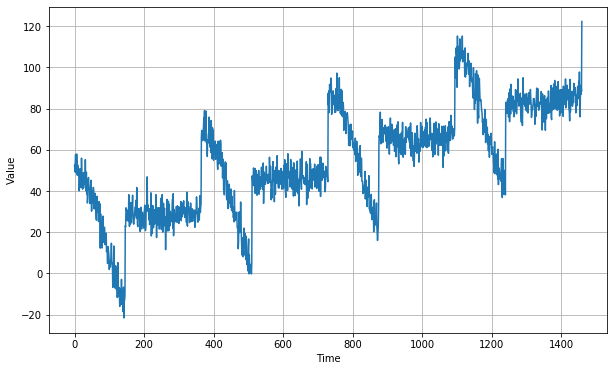

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [4]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

## Preprocessing with 1-Dimensional Convolutional Layers

In [5]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                       strides=1, padding="causal",
                       activation="relu",
                       input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 **(epoch/20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)

model.compile(optimizer = optimizer,
             loss = keras.losses.Huber(),
             metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
8/8 [==============================] - 0s 37ms/step - loss: 87.8346 - mae: 88.3341
Epoch 2/100
8/8 [==============================] - 0s 32ms/step - loss: 87.1197 - mae: 87.6191
Epoch 3/100
8/8 [==============================] - 0s 31ms/step - loss: 85.9241 - mae: 86.4234
Epoch 4/100
8/8 [==============================] - 0s 33ms/step - loss: 84.3720 - mae: 84.8713
Epoch 5/100
8/8 [==============================] - 0s 33ms/step - loss: 82.4703 - mae: 82.9696
Epoch 6/100
8/8 [==============================] - 0s 35ms/step - loss: 80.2434 - mae: 80.7428
Epoch 7/100
8/8 [==============================] - 0s 35ms/step - loss: 77.7459 - mae: 78.2453
Epoch 8/100
8/8 [==============================] - 0s 33ms/step - loss: 75.0957 - mae: 75.5952
Epoch 9/100
8/8 [==============================] - 0s 33ms/step - loss: 72.4508 - mae: 72.9503
Epoch 10/100
8/8 [==============================] - 0s 36ms/step - loss: 69.8938 - mae: 70.3934
Epoch 11/100
8/8 [==============================]

[1e-08, 0.0001, 0, 30]

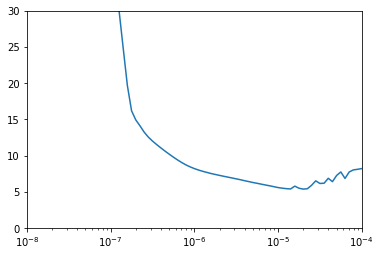

In [6]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-8, 1e-4, 0, 30])

It looks like the best learning rate is something like $10^{-5}$.

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                       strides=1, padding='causal',
                       activation='relu',
                       input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(optimizer = optimizer,
             loss = keras.losses.Huber(),
             metrics=['mae'])

model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",
                                                  save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.fit(train_set, epochs=500, validation_data=valid_set,
         callbacks=[model_checkpoint, early_stopping])


Epoch 1/500
8/8 [==============================] - 1s 138ms/step - loss: 56.9010 - mae: 57.4001 - val_loss: 28.7748 - val_mae: 29.2719
Epoch 2/500
8/8 [==============================] - 0s 48ms/step - loss: 26.1449 - mae: 26.6407 - val_loss: 38.9231 - val_mae: 39.4212
Epoch 3/500
8/8 [==============================] - 0s 49ms/step - loss: 17.3630 - mae: 17.8585 - val_loss: 30.1023 - val_mae: 30.6010
Epoch 4/500
8/8 [==============================] - 0s 53ms/step - loss: 12.0091 - mae: 12.4990 - val_loss: 24.5627 - val_mae: 25.0602
Epoch 5/500
8/8 [==============================] - 0s 50ms/step - loss: 9.9288 - mae: 10.4167 - val_loss: 18.8857 - val_mae: 19.3824
Epoch 6/500
8/8 [==============================] - 0s 50ms/step - loss: 8.8391 - mae: 9.3253 - val_loss: 16.0113 - val_mae: 16.5062
Epoch 7/500
8/8 [==============================] - 0s 50ms/step - loss: 8.0840 - mae: 8.5699 - val_loss: 12.5161 - val_mae: 13.0055
Epoch 8/500
8/8 [==============================] - 0s 52ms/step - 

In [8]:
model = keras.models.load_model('my_checkpoint.h5')

In [9]:
rnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time-window_size:-1, -1, 0]

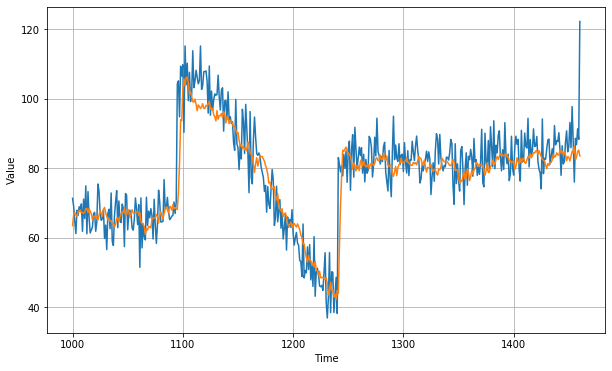

In [10]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [11]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.1126175

## Fully Convolutional Forecasting

In [12]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([])
model.add(keras.layers.InputLayer(input_shape=[None,1]))

for dilation_rate in (1,2,4,8,16,32):
    model.add(keras.layers.Conv1D(filters = 32,
                                 kernel_size=2,
                                 strides=1,
                                 dilation_rate=dilation_rate,
                                 padding='causal',
                                 activation='relu'))
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 **(epoch/30))
optimizer = keras.optimizers.Adam(lr=1e-4)

model.compile(optimizer = optimizer,
             loss = keras.losses.Huber(),
             metrics=['mae'])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 16ms/step - loss: 42.8547 - mae: 43.3537
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 42.5097 - mae: 43.0088
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 42.2001 - mae: 42.6992
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 41.9212 - mae: 42.4204
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 41.6268 - mae: 42.1259
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 41.2549 - mae: 41.7540
Epoch 7/100
8/8 [==============================] - 0s 14ms/step - loss: 40.7247 - mae: 41.2239
Epoch 8/100
8/8 [==============================] - 0s 14ms/step - loss: 39.9092 - mae: 40.4082
Epoch 9/100
8/8 [==============================] - 0s 15ms/step - loss: 38.6126 - mae: 39.1114
Epoch 10/100
8/8 [==============================] - 0s 12ms/step - loss: 36.4560 - mae: 36.9549
Epoch 11/100
8/8 [==============================]

[0.0001, 0.1, 0, 30]

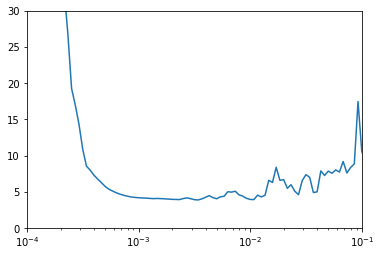

In [13]:
plt.semilogx(history.history['lr'], history.history['loss'])
plt.axis([1e-4, 1e-1, 0, 30])

Looks like the best learning rate is something like $3 \times 10^{-3}$.

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([])
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1,2,4,8,16,32):
    model.add(keras.layers.Conv1D(filters=32,
                                 kernel_size=2,
                                 strides=1,
                                 dilation_rate=dilation_rate,
                                 padding='causal',
                                 activation='relu'))
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

optimizer = keras.optimizers.Adam(lr=3e-3)
model.compile(optimizer = optimizer,
             loss = keras.losses.Huber(),
             metrics=['mae'])

model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",
                                                  save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

history = model.fit(train_set, epochs=500, validation_data=valid_set,
                   callbacks=[model_checkpoint, early_stopping])

Epoch 1/500
8/8 [==============================] - 1s 69ms/step - loss: 35.0415 - mae: 35.5398 - val_loss: 27.7350 - val_mae: 28.2323
Epoch 2/500
8/8 [==============================] - 0s 32ms/step - loss: 16.5340 - mae: 17.0268 - val_loss: 22.9680 - val_mae: 23.4653
Epoch 3/500
8/8 [==============================] - 0s 31ms/step - loss: 9.9610 - mae: 10.4493 - val_loss: 11.4980 - val_mae: 11.9885
Epoch 4/500
8/8 [==============================] - 0s 31ms/step - loss: 7.0720 - mae: 7.5569 - val_loss: 6.9162 - val_mae: 7.4011
Epoch 5/500
8/8 [==============================] - 0s 32ms/step - loss: 5.2544 - mae: 5.7352 - val_loss: 6.0920 - val_mae: 6.5746
Epoch 6/500
8/8 [==============================] - 0s 31ms/step - loss: 4.9055 - mae: 5.3857 - val_loss: 5.1250 - val_mae: 5.6046
Epoch 7/500
8/8 [==============================] - 0s 32ms/step - loss: 4.6442 - mae: 5.1227 - val_loss: 4.6190 - val_mae: 5.0966
Epoch 8/500
8/8 [==============================] - 0s 32ms/step - loss: 4.4623 

In [16]:
model = keras.models.load_model('my_checkpoint.h5')

In [18]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

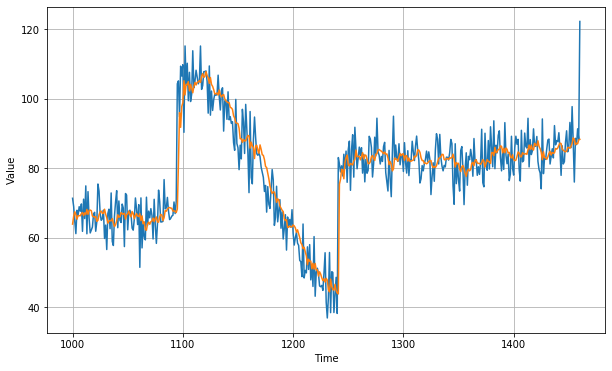

In [19]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.6285377